## SETUP

In [4]:
!pip install dezerogym

## ch05/dice.py

In [5]:
import numpy as np


def sample(dices=1):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x


trial = 1000
V, n = 0, 0

for _ in range(trial):
    s = sample()
    n += 1
    V += (s - V) / n
    print(V)

1.0
2.5
2.3333333333333335
2.0
2.2
2.8333333333333335
3.142857142857143
2.875
2.7777777777777777
2.6999999999999997
2.6363636363636362
2.583333333333333
2.4615384615384612
2.714285714285714
2.6666666666666665
2.625
2.5294117647058822
2.6666666666666665
2.5789473684210527
2.5
2.5238095238095237
2.5
2.4782608695652173
2.4166666666666665
2.56
2.576923076923077
2.5925925925925926
2.642857142857143
2.689655172413793
2.7666666666666666
2.7741935483870965
2.7187499999999996
2.7878787878787876
2.88235294117647
2.8285714285714283
2.8888888888888884
2.8648648648648645
2.894736842105263
2.846153846153846
2.8749999999999996
2.9512195121951215
2.952380952380952
2.976744186046511
2.9999999999999996
3.0666666666666664
3.1304347826086953
3.106382978723404
3.1666666666666665
3.142857142857143
3.12
3.0980392156862746
3.0961538461538463
3.056603773584906
3.055555555555556
3.0363636363636366
3.0000000000000004
2.9824561403508776
3.017241379310345
3.033898305084746
3.0500000000000003
3.0491803278688527
3.0

## ch05/mc_eval.py

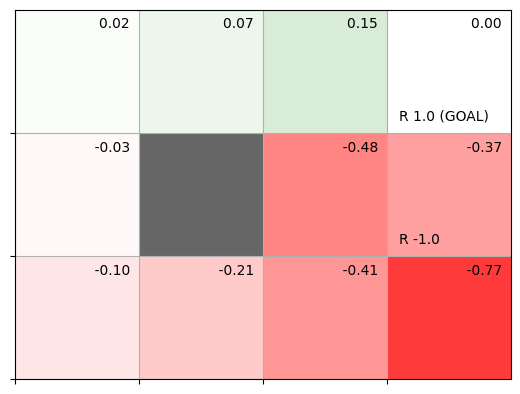

In [6]:
from collections import defaultdict
import numpy as np
from dezerogym.gridworld import GridWorld


class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0) # 가치를 리워드 얻은 것으로 직접 업데이트
        self.cnts = defaultdict(lambda: 0) # V 업데이트 시 나눠주기 위해서 카운트 관리
        self.memory = [] # 마지막에 업데이트 시작하기 때문에 메모리에 계속 넣어둠

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs) # probs에 따라서 샘플링

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data) # 메모리에 업데이트

    def reset(self):
        self.memory.clear() # 에피소드 끝나면 리셋

    def eval(self):
        G = 0
        for data in reversed(self.memory): # 뒤에서 부터 시작
            state, action, reward = data # 꺼내와서
            G = self.gamma * G + reward # r + gamma * v(s_t+1)
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]


env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break

        state = next_state

env.render_v(agent.V)

## ch05/mc_control.py

144
462
81
120
5
7
7
5
5
9


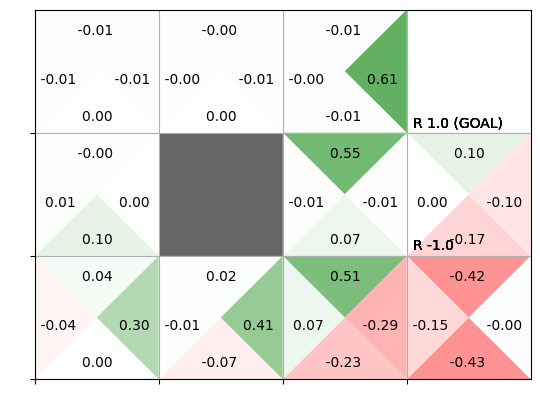

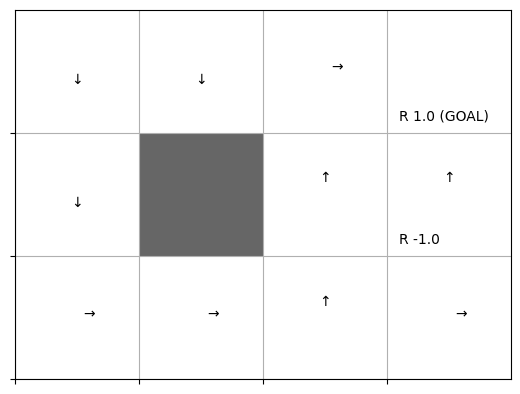

In [14]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        print(len(self.memory))
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = McAgent()

episodes = 10
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

## ch05/importance_sampling.py

In [15]:
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# =========== Expectation ==================
e = np.sum(x * pi)
print('E_pi[x]', e)

# =========== Monte Carlo ==================
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)
print('MC: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

# =========== Importance Sampling ===========
b = np.array([0.2, 0.2, 0.6])  #b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)
print('IS: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

E_pi[x] 2.7
MC: 2.82 (var: 0.29)
IS: 2.52 (var: 2.69)


## ch05/mc_control_offpolicy.py

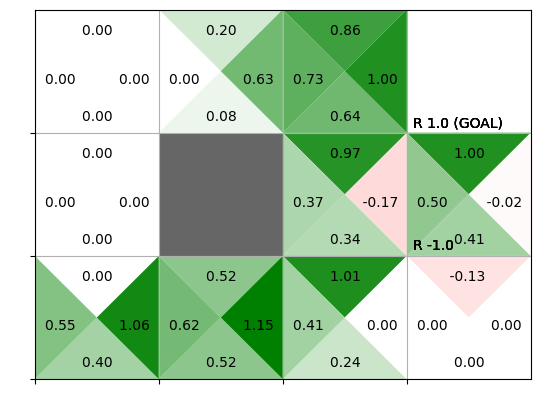

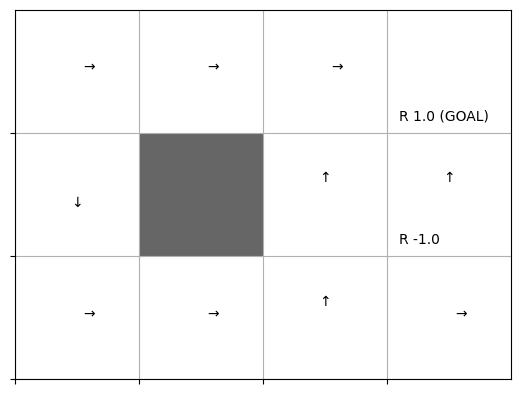

In [16]:
class McOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state] # 다른 분포로 샘플링
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            G = self.gamma * rho * G + reward
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)